Install necessary libraries `scipy` for scientific computing, `seaborn` for data visualization capabilities, and `optuna` for hyperparameter tuning.


In [ ]:
# Install Required Libraries
!pip install scipy seaborn optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


"Mount Google Drive to access the data

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries. `numpy` for numerical operations, `scipy.io` for loading MATLAB files, `sklearn` for machine learning model creation, training, and evaluation, `matplotlib.pyplot` and `seaborn` for data visualization, and `optuna` for hyperparameter tuning and import libries for ML models and evaluating them


In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

Load the coherence data from a MATLAB (.mat) file stored in Google Drive. It contains the coherence matrices for Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC). Use `scipy.io.loadmat` to read the .mat file


In [ ]:
# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/Data_files/Coherence.mat'
mat = scipy.io.loadmat(mat_file_path)
coherence_data = mat['Coherence'][0, 0]

Extract the Coherence data for different categories: Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD)

In [ ]:
# Extracting data in different categories (AZ, FTD, HC)
coherence_FTD_F = coherence_data['FTD']
coherence_HC_F = coherence_data['HC']

Extract the data corresponding to the 3rd frequency band (index 2) and then reshape the extracted data

In [ ]:
# Extract the 3rd frequency band (index 2) and normalize the data
coherence_FTD = coherence_FTD_F[:, 2, :].reshape(2346, 1, 23)
coherence_HC = coherence_HC_F[:, 2, :].reshape(2346, 1, 29)

# Optional: To test whether the data is converted properly into numpy arrays
print(coherence_FTD.shape)
print(coherence_HC.shape)

(2346, 1, 23)
(2346, 1, 29)


Reconstructs the coherence matrix from the extracted coherence data. The function iterates over frequency bands and subjects, creating a 68x68 matrix with coherence values. The rebuilt matrices are stored in a 4D array with dimensions corresponding to regions, regions, bands, and subjects

In [ ]:
# Function to rebuild the coherence matrix from the coherence data
def rebuild_matrix(coherence_data):
    n_regions = 68
    n_data = coherence_data.shape[2]
    n_bands = coherence_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = coherence_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data

Reconstruct the coherence matrices for each category (AZ, FTD) and check the shapes of the resulting matrices to ensure that they have been reconstructed correctly and have the expected dimensions

In [ ]:
# Rebuild the coherence matrices
coherence_FTD_rebuilt = rebuild_matrix(coherence_FTD)
coherence_HC_rebuilt = rebuild_matrix(coherence_HC)

# Check the shapes to ensure correctness
print('Coherence_FTD_rebuilt shape:', coherence_FTD_rebuilt.shape)
print('Coherence_HC_rebuilt shape:', coherence_HC_rebuilt.shape)


Coherence_FTD_rebuilt shape: (68, 68, 1, 23)
Coherence_HC_rebuilt shape: (68, 68, 1, 29)


Visualize a single coherence matrix using a heatmap. Use `seaborn` for better visual representation. Extract the coherence matrix for the first patient in the AZ category and use the visualization function to plot it, ensuring that the data is ordered correctly


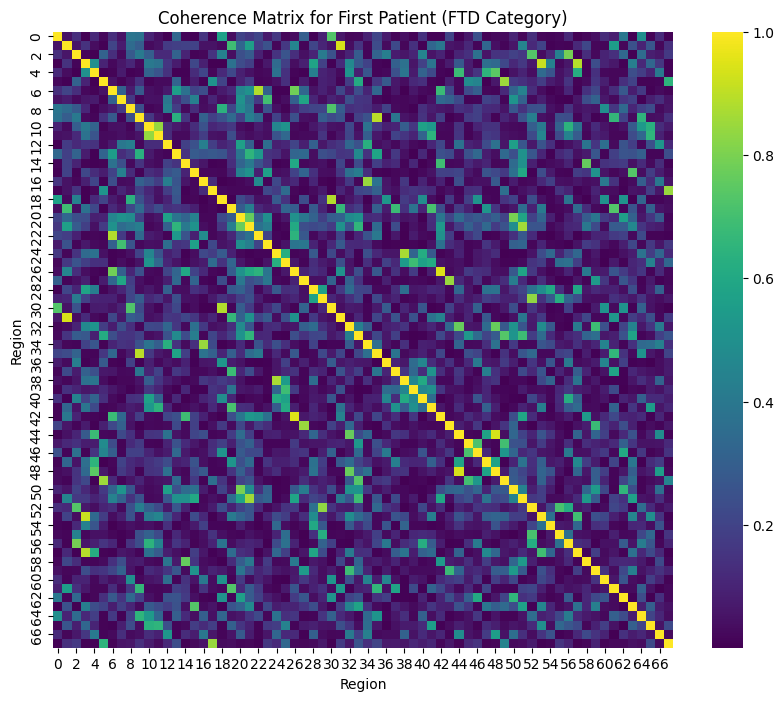

In [ ]:
# Function to visualize a single coherence matrix
def visualize_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel('Region')
    plt.show()

# Extract the coherence matrix for the first patient in the FTD category
single_patient_ftd_matrix = coherence_FTD_rebuilt[:, :, 0, 0]  # Choosing the first frequency band (index 0)

# Visualize the coherence matrix for the first patient in the FTD category
visualize_matrix(single_patient_ftd_matrix, 'Coherence Matrix for First Patient (FTD Category)')

Extracts edge features from the coherence matrices and assigns labels to them. The function iterates over the subjects and bands, extracting the upper triangular part of each coherence matrix (excluding the diagonal). These edge attributes are then stored in a feature array, and the corresponding labels are stored in a label array




In [ ]:

# Extract edge features and labels
def extract_edge_features_labels(data, label):
    features = []
    labels = []
    for i in range(data.shape[3]):
        for j in range(data.shape[2]):
            matrix = data[:, :, j, i]
            edge_attr = matrix[np.triu_indices_from(matrix, k=1)]
            features.append(edge_attr)
            labels.append(label)
    return np.array(features), np.array(labels)

Use the `extract_edge_features_labels` function to extract features and labels for AZ vs FTD classification


In [ ]:
# Extract features and labels for AZ vs FTD
features_ftd_hc, labels_ftd_hc = extract_edge_features_labels(coherence_HC_rebuilt, 1)
features_ftd_hc_, labels_ftd_hc_ = extract_edge_features_labels(coherence_FTD_rebuilt, 0)
features_ftd_hc = np.concatenate((features_ftd_hc, features_ftd_hc_), axis=0)
labels_ftd_hc = np.concatenate((labels_ftd_hc, labels_ftd_hc_), axis=0)

Split the extracted features and labels into training and testing sets for AZ vs FTD classification


In [ ]:
# Split data into training and testing sets for AZ vs HC
X_train_ftd_hc, X_test_ftd_hc, y_train_ftd_hc, y_test_ftd_hc = train_test_split(features_ftd_hc, labels_ftd_hc, test_size=0.2, random_state=38)


In [ ]:
# Hyperparameter tuning using Optuna for GaussianNB (FTD vs HC)
def objective_gaussian_nb(trial):
    # GaussianNB does not have hyperparameters to tune via Optuna

    gaussian_nb = GaussianNB()
    gaussian_nb.fit(X_train_ftd_hc, y_train_ftd_hc)
    y_pred = gaussian_nb.predict(X_test_ftd_hc)
    return accuracy_score(y_test_ftd_hc, y_pred)

study_gaussian_nb_ftd_hc = optuna.create_study(direction='maximize')
study_gaussian_nb_ftd_hc.optimize(objective_gaussian_nb, n_trials=1)  # No real hyperparameters to optimize

best_params_gaussian_nb_ftd_hc = study_gaussian_nb_ftd_hc.best_params
print("Best parameters for GaussianNB (FTD vs HC):", best_params_gaussian_nb_ftd_hc)

gaussian_nb_ftd_hc = GaussianNB()
gaussian_nb_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = gaussian_nb_ftd_hc.predict(X_test_ftd_hc)
print("Classification Report for GaussianNB (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for GaussianNB (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for GaussianNB (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))

[I 2024-08-07 09:18:04,873] A new study created in memory with name: no-name-abe81b8c-8063-4fd0-aad8-e3f284bf4d74
[I 2024-08-07 09:18:04,884] Trial 0 finished with value: 0.9090909090909091 and parameters: {}. Best is trial 0 with value: 0.9090909090909091.


Best parameters for GaussianNB (FTD vs HC): {}
Classification Report for GaussianNB (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for GaussianNB (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for GaussianNB (FTD vs HC): 0.9090909090909091


In [ ]:
import optuna
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for BaggingClassifier
def objective_bagging(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False])
    }

    bagging = BaggingClassifier(**param)
    scores = cross_val_score(bagging, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_bagging = optuna.create_study(direction='maximize')
study_bagging.optimize(objective_bagging, n_trials=30)

best_params_bagging = study_bagging.best_params
print("Best parameters for BaggingClassifier (FTD vs HC):", best_params_bagging)

bagging_best = BaggingClassifier(**best_params_bagging)
bagging_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = bagging_best.predict(X_test_ftd_hc)

print("Classification Report for BaggingClassifier (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for BaggingClassifier (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for BaggingClassifier (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-08-07 09:18:10,383] A new study created in memory with name: no-name-4c7ae490-1790-4f3e-a289-f96652ef85c4
[I 2024-08-07 09:18:19,707] Trial 0 finished with value: 0.74 and parameters: {'n_estimators': 167, 'max_samples': 0.6792294730966068, 'max_features': 0.275846386007011, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 0 with value: 0.74.
[I 2024-08-07 09:18:26,240] Trial 1 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 90, 'max_samples': 0.9746992806253507, 'max_features': 0.3864119876354104, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-08-07 09:18:30,979] Trial 2 finished with value: 0.765 and parameters: {'n_estimators': 36, 'max_samples': 0.5793211879677904, 'max_features': 0.7908082892820799, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-08-07 09:18:34,655] Trial 3 finished with value: 0.71 and parameters: {'n_es

Best parameters for BaggingClassifier (FTD vs HC): {'n_estimators': 178, 'max_samples': 0.9938021265492372, 'max_features': 0.3606676310685338, 'bootstrap': False, 'bootstrap_features': True}
Classification Report for BaggingClassifier (FTD vs HC):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.83      0.83      0.83         6

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11

Confusion Matrix for BaggingClassifier (FTD vs HC):
[[4 1]
 [1 5]]
Accuracy for BaggingClassifier (FTD vs HC): 0.8181818181818182


In [ ]:
# Hyperparameter tuning using Optuna for ExtraTreesClassifier
def objective_extra_trees(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    extra_trees = ExtraTreesClassifier(**param)
    scores = cross_val_score(extra_trees, X_train_ftd_hc, y_train_ftd_hc, cv=3)
    return scores.mean()

study_extra_trees = optuna.create_study(direction='maximize')
study_extra_trees.optimize(objective_extra_trees, n_trials=50)

best_params_extra_trees = study_extra_trees.best_params
print("Best parameters for ExtraTreesClassifier (FTD vs HC):", best_params_extra_trees)

extra_trees_best = ExtraTreesClassifier(**best_params_extra_trees)
extra_trees_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = extra_trees_best.predict(X_test_ftd_hc)
print("Classification Report for ExtraTreesClassifier (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for ExtraTreesClassifier (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for ExtraTreesClassifier (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-07-22 08:59:27,392] A new study created in memory with name: no-name-23994f25-780f-404e-8acf-6c06e7bf8245
[I 2024-07-22 08:59:28,192] Trial 0 finished with value: 0.706959706959707 and parameters: {'n_estimators': 142, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.706959706959707.
[I 2024-07-22 08:59:28,648] Trial 1 finished with value: 0.7307692307692308 and parameters: {'n_estimators': 78, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7307692307692308.
[I 2024-07-22 08:59:29,668] Trial 2 finished with value: 0.7307692307692308 and parameters: {'n_estimators': 174, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7307692307692308.
[I 2024-07-22 08:59:30,367] Trial 3 finished with value: 0.7783882783882783 and parameters: {'n_estimators': 120, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.

Best parameters for ExtraTreesClassifier (FTD vs HC): {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}
Classification Report for ExtraTreesClassifier (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for ExtraTreesClassifier (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for ExtraTreesClassifier (FTD vs HC): 0.9090909090909091


In [ ]:
# Hyperparameter tuning using Optuna for SVC
def objective_svc(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    svc = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    # svc.fit(X_train_ftd_hc, y_train_ftd_hc)
    # y_pred = svc.predict(X_test_ftd_hc)
    # return accuracy_score(y_test_ftd_hc, y_pred)
    scores = cross_val_score(svc, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()


study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=50)

best_params_svc = study_svc.best_params
print("Best parameters for SVC (FTD vs HC):", best_params_svc)

svc_best = SVC(**best_params_svc)
svc_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = svc_best.predict(X_test_ftd_hc)
print("Classification Report for SVC (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for SVC (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for SVC (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-07-22 08:56:35,990] A new study created in memory with name: no-name-6dc53e10-9b52-4655-af1d-fb820cef4dcd
<ipython-input-17-8d8e9ca84416>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
<ipython-input-17-8d8e9ca84416>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-07-22 08:56:36,084] Trial 0 finished with value: 0.7150000000000001 and parameters: {'C': 67.90712994373361, 'gamma': 0.0017035421374919102, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.7150000000000001.
<ipython-input-17-8d8e9ca84416>:3: FutureWarning: suggest_loguniform has been depreca

Best parameters for SVC (FTD vs HC): {'C': 4.115770269418699, 'gamma': 0.003852086974868314, 'kernel': 'poly'}
Classification Report for SVC (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for SVC (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for SVC (FTD vs HC): 0.9090909090909091


In [ ]:
# Hyperparameter tuning using Optuna for BernoulliNB
def objective_bernoulli_nb(trial):
    param = {
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'binarize': trial.suggest_loguniform('binarize', 1e-3, 1.0)
    }
    bernoulli_nb = BernoulliNB(**param)
    scores = cross_val_score(bernoulli_nb, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_bernoulli_nb = optuna.create_study(direction='maximize')
study_bernoulli_nb.optimize(objective_bernoulli_nb, n_trials=50)

best_params_bernoulli_nb = study_bernoulli_nb.best_params
print("Best parameters for BernoulliNB (FTD vs HC):", best_params_bernoulli_nb)

bernoulli_nb_best = BernoulliNB(**best_params_bernoulli_nb)
bernoulli_nb_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = bernoulli_nb_best.predict(X_test_ftd_hc)
print("Classification Report for BernoulliNB (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for BernoulliNB (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for BernoulliNB (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-07-22 08:55:46,045] A new study created in memory with name: no-name-cb1c78ca-b71e-485b-ba4b-6b1779ba02c8
<ipython-input-15-d478ffcce77e>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
<ipython-input-15-d478ffcce77e>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'binarize': trial.suggest_loguniform('binarize', 1e-3, 1.0)
[I 2024-07-22 08:55:46,096] Trial 0 finished with value: 0.71 and parameters: {'alpha': 0.20113531709109264, 'binarize': 0.3555937570430104}. Best is trial 0 with value: 0.71.
<ipython-input-15-d478ffcce77e>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Best parameters for BernoulliNB (FTD vs HC): {'alpha': 0.019643224510086595, 'binarize': 0.07385512851360601}
Classification Report for BernoulliNB (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for BernoulliNB (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for BernoulliNB (FTD vs HC): 0.9090909090909091


In [ ]:
# Hyperparameter tuning using Optuna for LinearDiscriminantAnalysis
def objective_lda(trial):
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    if solver == 'lsqr' or solver == 'eigen':
        shrinkage = trial.suggest_categorical('shrinkage', [None, 'auto', 0.1, 0.5, 1.0])
    else:
        shrinkage = None

    param = {
        'solver': solver,
        'shrinkage': shrinkage
    }

    lda = LinearDiscriminantAnalysis(**param)
    #y_pred = lda.predict(X_test_ftd_hc)
    # return accuracy_score(y_test_az_hc, y_pred)
    scores = cross_val_score(lda, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_lda = optuna.create_study(direction='maximize')
study_lda.optimize(objective_lda, n_trials=20)

best_params_lda = study_lda.best_params
print("Best parameters for LinearDiscriminantAnalysis (FTD vs HC):", best_params_lda)

lda_best = LinearDiscriminantAnalysis(**best_params_lda)
lda_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = lda_best.predict(X_test_ftd_hc)
print("Classification Report for LinearDiscriminantAnalysis (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for LinearDiscriminantAnalysis (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for LinearDiscriminantAnalysis (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-07-22 08:43:20,781] A new study created in memory with name: no-name-42821d16-1538-46cd-9f16-aec5c748b42d
[I 2024-07-22 08:44:25,743] Trial 0 finished with value: 0.735 and parameters: {'solver': 'eigen', 'shrinkage': 1.0}. Best is trial 0 with value: 0.735.
[I 2024-07-22 08:44:26,035] Trial 1 finished with value: 0.74 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.74.
[I 2024-07-22 08:44:26,334] Trial 2 finished with value: 0.74 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.74.
[I 2024-07-22 08:45:57,574] Trial 3 finished with value: 0.5650000000000001 and parameters: {'solver': 'lsqr', 'shrinkage': 'auto'}. Best is trial 1 with value: 0.74.
[I 2024-07-22 08:46:49,452] Trial 4 finished with value: 0.5650000000000001 and parameters: {'solver': 'eigen', 'shrinkage': 0.1}. Best is trial 1 with value: 0.74.
[I 2024-07-22 08:48:36,906] Trial 5 finished with value: 0.5650000000000001 and parameters: {'solver': 'eigen', 'shrinkage': 'auto'}. Best 

Best parameters for LinearDiscriminantAnalysis (FTD vs HC): {'solver': 'svd'}
Classification Report for LinearDiscriminantAnalysis (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for LinearDiscriminantAnalysis (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for LinearDiscriminantAnalysis (FTD vs HC): 0.9090909090909091


In [ ]:
# Hyperparameter tuning using Optuna for RandomForestClassifier
def objective_random_forest(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    random_forest = RandomForestClassifier(**param)
    scores = cross_val_score(random_forest, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_random_forest = optuna.create_study(direction='maximize')
study_random_forest.optimize(objective_random_forest, n_trials=30)

best_params_random_forest = study_random_forest.best_params
print("Best parameters for RandomForestClassifier (FTD vs HC):", best_params_random_forest)

random_forest_best = RandomForestClassifier(**best_params_random_forest)
random_forest_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = random_forest_best.predict(X_test_ftd_hc)
print("Classification Report for RandomForestClassifier (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for RandomForestClassifier (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for RandomForestClassifier (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-07-22 08:57:43,754] A new study created in memory with name: no-name-e4a1077d-44d2-4617-be12-25d293e350e0
[I 2024-07-22 08:57:46,351] Trial 0 finished with value: 0.76 and parameters: {'n_estimators': 153, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.76.
[I 2024-07-22 08:57:49,104] Trial 1 finished with value: 0.76 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.76.
[I 2024-07-22 08:57:50,355] Trial 2 finished with value: 0.7849999999999999 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7849999999999999.
[I 2024-07-22 08:57:52,807] Trial 3 finished with value: 0.76 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.7849999999999999.
[I 2024-07-22 08:57:53,434] Trial 4 finished with va

Best parameters for RandomForestClassifier (FTD vs HC): {'n_estimators': 48, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4}
Classification Report for RandomForestClassifier (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for RandomForestClassifier (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for RandomForestClassifier (FTD vs HC): 0.9090909090909091


In [ ]:
import optuna
from sklearn.svm import NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for NuSVC (FTD vs HC)
def objective_nusvc_ftd_hc(trial):
    nu = trial.suggest_uniform('nu', 0.1, 0.9)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    nusvc = NuSVC(nu=nu, gamma=gamma, kernel=kernel, probability=True)

    try:
        scores = cross_val_score(nusvc, X_train_ftd_hc, y_train_ftd_hc, cv=10)
        return scores.mean()
    except ValueError as e:
        # If the combination is not feasible, return a very low score
        return 0.0

# Create and optimize the Optuna study
study_nusvc_ftd_hc = optuna.create_study(direction='maximize')
study_nusvc_ftd_hc.optimize(objective_nusvc_ftd_hc, n_trials=50)

# Get the best parameters and train the model
best_params_nusvc_ftd_hc = study_nusvc_ftd_hc.best_params
print("Best parameters for NuSVC (FTD vs HC):", best_params_nusvc_ftd_hc)

nusvc_ftd_hc = NuSVC(**best_params_nusvc_ftd_hc, probability=True)
nusvc_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = nusvc_ftd_hc.predict(X_test_ftd_hc)

# Predict and evaluate the model
print("Classification Report for NuSVC (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for NuSVC (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for NuSVC (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-08-07 09:13:45,868] A new study created in memory with name: no-name-4e7a0459-1632-442f-ac61-2cacd54e56c7
<ipython-input-16-ec37ee8a9474>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nu = trial.suggest_uniform('nu', 0.1, 0.9)
<ipython-input-16-ec37ee8a9474>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-08-07 09:13:45,969] Trial 0 finished with value: 0.5599999999999999 and parameters: {'nu': 0.616147646878789, 'gamma': 0.5152702268788907, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5599999999999999.
<ipython-input-16-ec37ee8a9474>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature w

Best parameters for NuSVC (FTD vs HC): {'nu': 0.7040078760735742, 'gamma': 0.2418275078875602, 'kernel': 'poly'}
Classification Report for NuSVC (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for NuSVC (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for NuSVC (FTD vs HC): 0.9090909090909091


In [ ]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for AdaBoostClassifier
def objective_adaboost(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
    }

    adaboost = AdaBoostClassifier(
        **param
    )

    scores = cross_val_score(adaboost, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_adaboost = optuna.create_study(direction='maximize')
study_adaboost.optimize(objective_adaboost, n_trials=30)

best_params_adaboost = study_adaboost.best_params
print("Best parameters for AdaBoostClassifier (FTD vs HC):", best_params_adaboost)

# Create and train the best AdaBoost model
adaboost_best = AdaBoostClassifier(
    n_estimators=best_params_adaboost['n_estimators'],
    learning_rate=best_params_adaboost['learning_rate'],
    algorithm=best_params_adaboost['algorithm']
)
adaboost_best.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = adaboost_best.predict(X_test_ftd_hc)

print("Classification Report for AdaBoostClassifier (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for AdaBoostClassifier (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for AdaBoostClassifier (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-08-07 09:25:58,481] A new study created in memory with name: no-name-7183bf9a-e305-4225-934c-96033a771cd3
[I 2024-08-07 09:26:45,193] Trial 0 finished with value: 0.665 and parameters: {'n_estimators': 280, 'learning_rate': 0.21110432052739397, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.665.
[I 2024-08-07 09:26:56,114] Trial 1 finished with value: 0.835 and parameters: {'n_estimators': 72, 'learning_rate': 0.21332483701136196, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.835.
[I 2024-08-07 09:27:09,336] Trial 2 finished with value: 0.765 and parameters: {'n_estimators': 83, 'learning_rate': 0.9785250296507765, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.835.
[I 2024-08-07 09:27:20,346] Trial 3 finished with value: 0.7849999999999999 and parameters: {'n_estimators': 68, 'learning_rate': 0.9260733551677816, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.835.
[I 2024-08-07 09:27:57,893] Trial 4 finished with value: 0.8099999999999999 and paramete

Best parameters for AdaBoostClassifier (FTD vs HC): {'n_estimators': 218, 'learning_rate': 0.014680509200320546, 'algorithm': 'SAMME'}
Classification Report for AdaBoostClassifier (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for AdaBoostClassifier (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for AdaBoostClassifier (FTD vs HC): 0.9090909090909091


In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for LogisticRegression (FTD vs HC)
def objective_logreg_ftd_hc(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    logreg = LogisticRegression(C=C, solver=solver, random_state=42)
    scores = cross_val_score(logreg, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

# Create and optimize the Optuna study
study_logreg_ftd_hc = optuna.create_study(direction='maximize')
study_logreg_ftd_hc.optimize(objective_logreg_ftd_hc, n_trials=50)

# Get the best parameters and train the model
best_params_logreg_ftd_hc = study_logreg_ftd_hc.best_params
print("Best parameters for LogisticRegression (FTD vs HC):", best_params_logreg_ftd_hc)

logreg_ftd_hc = LogisticRegression(**best_params_logreg_ftd_hc, random_state=42)
logreg_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)

# Predict and evaluate the model
y_pred_ftd_hc = logreg_ftd_hc.predict(X_test_ftd_hc)
print("Classification Report for LogisticRegression (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for LogisticRegression (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for LogisticRegression (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-08-07 09:44:00,084] A new study created in memory with name: no-name-7629dcd0-e34e-4c5e-9dd7-95ca77ffb9fe
<ipython-input-34-9ec206934983>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2024-08-07 09:44:00,387] Trial 0 finished with value: 0.7150000000000001 and parameters: {'C': 6.698043033788409, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7150000000000001.
<ipython-input-34-9ec206934983>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached whic

Best parameters for LogisticRegression (FTD vs HC): {'C': 0.14740466893997287, 'solver': 'saga'}
Classification Report for LogisticRegression (FTD vs HC):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for LogisticRegression (FTD vs HC):
[[4 1]
 [0 6]]
Accuracy for LogisticRegression (FTD vs HC): 0.9090909090909091


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Import necessary libraries for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the classifiers with the best parameters
classifiers_ftd_hc = {
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(solver='svd'),

    'SVC': SVC(
        C=4.115770269418699,
        gamma=0.003852086974868314,
        kernel='poly',
        probability=True
    ),

    'BernoulliNB': BernoulliNB(
        alpha=0.019643224510086595,
        binarize=0.07385512851360601
    ),

    'RandomForestClassifier': RandomForestClassifier(
        n_estimators=48,
        max_depth=3,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42
    ),

    'ExtraTreesClassifier': ExtraTreesClassifier(
        n_estimators=117,
        max_depth=4,
        min_samples_split=7,
        min_samples_leaf=4,
        random_state=42
    ),

    'GaussianNB': GaussianNB(),  # GaussianNB does not have hyperparameters to tune

    'BaggingClassifier': BaggingClassifier(
        n_estimators=178,
        max_samples=0.9938021265492372,
        max_features=0.3606676310685338,
        bootstrap=False,
        bootstrap_features=True,
        random_state=42
    ),

    'NuSVC': NuSVC(
        nu=0.7040078760735742,
        gamma=0.2418275078875602,
        kernel='poly',
        probability=True
    ),

    'AdaBoostClassifier': AdaBoostClassifier(
        n_estimators=218,
        learning_rate=0.014680509200320546,
        algorithm='SAMME',
        random_state=42
    ),

    'LogisticRegression': LogisticRegression(
        C=0.14740466893997287,
        solver='saga'
    )
}

# Perform cross-validation and store the results
cv_results_ftd_hc = {}

for name, clf in classifiers_ftd_hc.items():
    scores = cross_val_score(clf, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    cv_results_ftd_hc[name] = scores

# Print summary of cross-validation results
print("\nSummary of cross-validation results (FTD vs HC):")
for name, scores in cv_results_ftd_hc.items():
    print(f"{name}: Mean accuracy = {scores.mean():.4f}, Standard deviation = {scores.std():.4f}")

# Choose the best model based on mean cross-validation accuracy
best_model_name_ftd_hc = max(cv_results_ftd_hc, key=lambda k: cv_results_ftd_hc[k].mean())
print(f"\nBest model based on cross-validation (FTD vs HC): {best_model_name_ftd_hc}")

# Evaluate the best model on the test set
best_model_ftd_hc = classifiers_ftd_hc[best_model_name_ftd_hc]
best_model_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = best_model_ftd_hc.predict(X_test_ftd_hc)

print(f"\nClassification Report for {best_model_name_ftd_hc} (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print(f"Confusion Matrix for {best_model_name_ftd_hc} (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print(f"Accuracy for {best_model_name_ftd_hc} (FTD vs HC): {accuracy_score(y_test_ftd_hc, y_pred_ftd_hc):.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 


Summary of cross-validation results (FTD vs HC):
LinearDiscriminantAnalysis: Mean accuracy = 0.8000, Standard deviation = 0.2179
SVC: Mean accuracy = 0.8800, Standard deviation = 0.1208
BernoulliNB: Mean accuracy = 0.8500, Standard deviation = 0.1225
RandomForestClassifier: Mean accuracy = 0.8500, Standard deviation = 0.1658
ExtraTreesClassifier: Mean accuracy = 0.8750, Standard deviation = 0.1250
GaussianNB: Mean accuracy = 0.8550, Standard deviation = 0.1193
BaggingClassifier: Mean accuracy = 0.8050, Standard deviation = 0.1863
NuSVC: Mean accuracy = 0.8550, Standard deviation = 0.1193
AdaBoostClassifier: Mean accuracy = 0.8250, Standard deviation = 0.2250
LogisticRegression: Mean accuracy = 0.8250, Standard deviation = 0.1601

Best model based on cross-validation (FTD vs HC): SVC

Classification Report for SVC (FTD vs HC):
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.60      0.43      0.50         

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


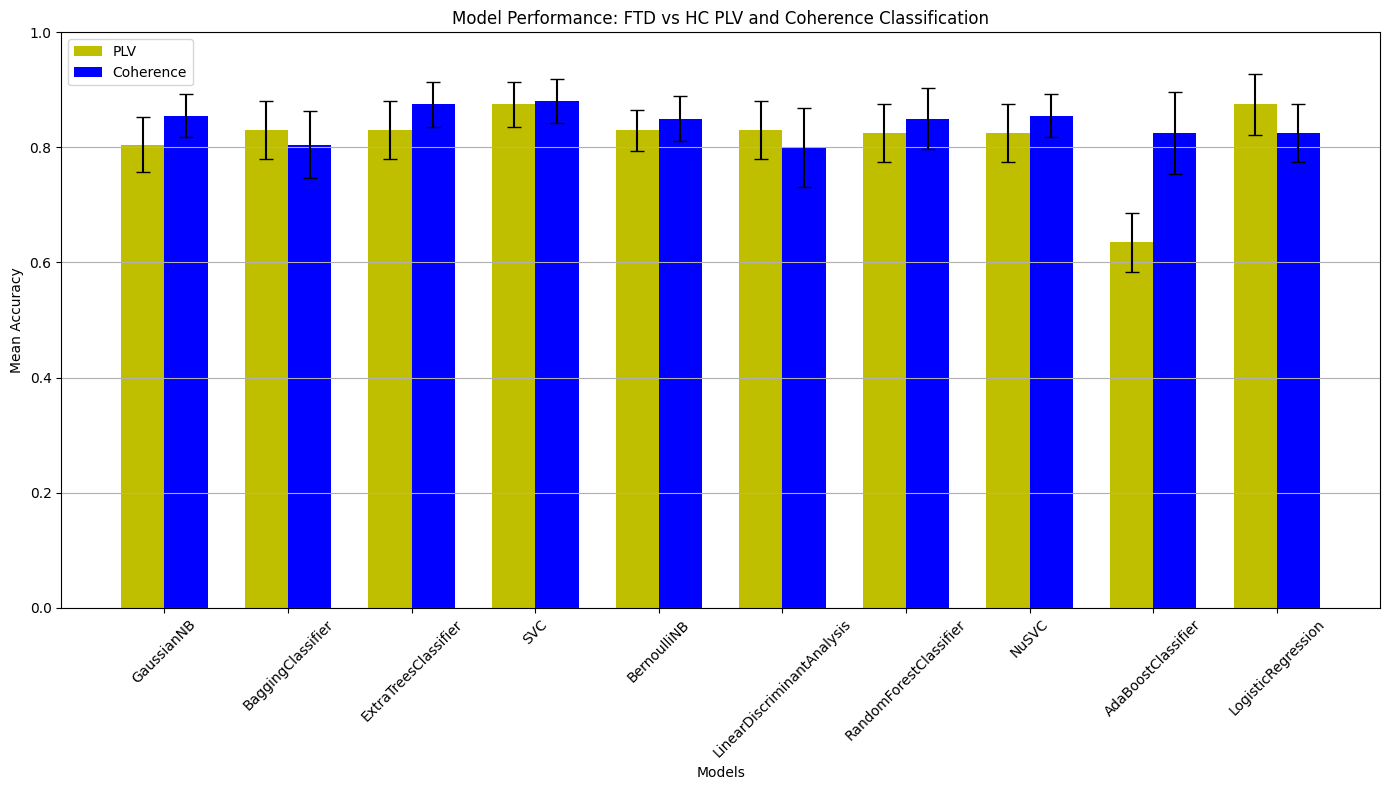

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ordered models (same as previous example)
models = ['GaussianNB', 'BaggingClassifier', 'ExtraTreesClassifier', 'SVC', 'BernoulliNB',
          'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'NuSVC', 'AdaBoostClassifier',
          'LogisticRegression']

# Data for FTD vs HC PLV classification (updated)
mean_acc_plv = [0.8050, 0.8300, 0.8300, 0.8750, 0.8300,
                0.8300, 0.8250, 0.8250, 0.6350, 0.8750]
std_dev_plv = [0.1491, 0.1584, 0.1584, 0.1250, 0.1122,
               0.1584, 0.1601, 0.1601, 0.1629, 0.1677]

# Data for FTD vs HC Coherence classification (kept same as before)
mean_acc_coherence = [0.8550, 0.8050, 0.8750, 0.8800, 0.8500,
                      0.8000, 0.8500, 0.8550, 0.8250, 0.8250]
std_dev_coherence = [0.1193, 0.1863, 0.1250, 0.1208, 0.1225,
                     0.2179, 0.1658, 0.1193, 0.2250, 0.1601]

# Calculate standard error
n = 10
std_err_plv = [std / np.sqrt(n) for std in std_dev_plv]
std_err_coherence = [std / np.sqrt(n) for std in std_dev_coherence]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Bar plots
bars_plv = ax.bar(index - bar_width/2, mean_acc_plv, bar_width, yerr=std_err_plv, capsize=5, label='PLV', color='y')
bars_coherence = ax.bar(index + bar_width/2, mean_acc_coherence, bar_width, yerr=std_err_coherence, capsize=5, label='Coherence', color='b')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Model Performance: FTD vs HC PLV and Coherence Classification')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend()

ax.set_ylim(0, 1)
# Add grid
ax.yaxis.grid(True)

# Show plot
plt.tight_layout()
plt.show()
